In [85]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import talib

In [86]:
stock_id = '2376.TW 2377.TW'
df = yf.download(stock_id, start='2018-01-01', end='2021-07-21')

[*********************100%***********************]  2 of 2 completed


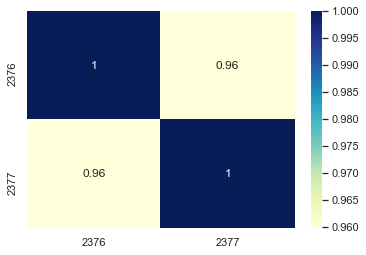

In [87]:
columns = [('Close', x) for x in stock_id.split()]
df2 = df[columns]
df2.columns = [x.replace('.TW', '') for x in stock_id.split()]
ax = sns.heatmap(df2.corr(), annot=True, annot_kws={"size": 12}, cmap="YlGnBu")

In [88]:
df = df['Adj Close']
df

,2376.TW,2377.TW
Date,,
2018-01-02,43.259216,70.392532
2018-01-03,45.307480,74.885666
2018-01-04,48.502762,75.942871
2018-01-05,47.683456,78.057297
2018-01-08,49.977505,78.145393
...,...,...
2021-07-14,95.300003,151.000000
2021-07-15,97.400002,154.000000
2021-07-16,97.800003,153.500000


In [89]:
cov_matrix = df.pct_change().apply(lambda x: np.log(1+x)).cov()

ind_er = df.resample('Y').last().pct_change().mean()

p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights

num_assets = len(df.columns)
num_portfolios = 10000

np.random.random(4)

for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, ind_er) # Returns are the product of individual expected returns of asset and its 
                                      # weights 
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # Daily standard deviation
    ann_sd = sd*np.sqrt(250) # Annual standard deviation = volatility
    p_vol.append(ann_sd)
    
data = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(df.columns.tolist()):
    #print(counter, symbol)
    data[symbol+' weight'] = [w[counter] for w in p_weights]
portfolios  = pd.DataFrame(data)
portfolios.head()

,Returns,Volatility,2376.TW weight,2377.TW weight
0,0.356551,0.359741,0.480004,0.519996
1,0.334631,0.358754,0.293882,0.706118
2,0.373607,0.369643,0.624819,0.375181
3,0.384186,0.379538,0.714642,0.285358
4,0.358072,0.360306,0.492920,0.507080


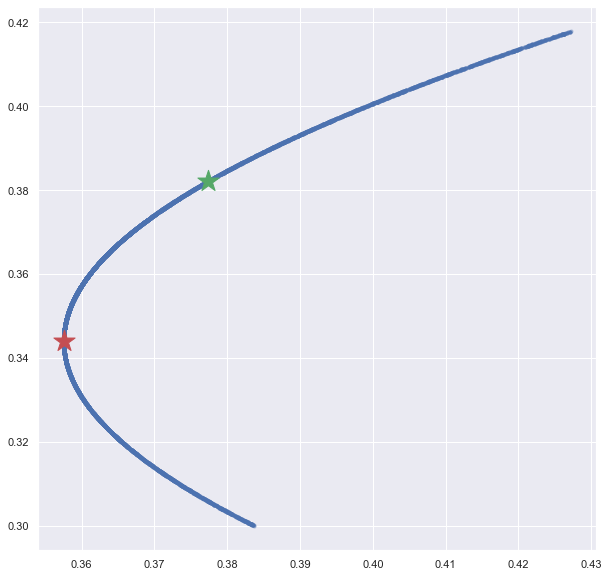

In [90]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]

rf = 0.01 # risk factor
# Max Sharpe Ratio
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port

plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500)

In [97]:

df = yf.download("3231.TW", start="2021-01-01", end="2021-07-21")
sma5 = pd.DataFrame()
sma5['sma5'] = talib.SMA(df['Adj Close'], timeperiod=5)
sma20 = pd.DataFrame()
sma20['sma20'] = talib.SMA(df['Adj Close'], timeperiod=20)
def ohlc_plot(Data, name):
    BAR_WIDTH = 8
    plt.figure(figsize=(20,10))
    for i in range(len(Data)): 
        plt.vlines(x = Data.index[i], ymin = Data.iloc[i, 2], ymax = Data.iloc[i, 1], 
                   color = 'black', linewidth = 1)

        if Data.iloc[i, 0] > Data.iloc[i, 3]:
            color_Data = 'green'
            plt.vlines(x = Data.index[i], ymin = Data.iloc[i, 3], ymax = Data.iloc[i, 0], 
                       color = color_Data, linewidth = BAR_WIDTH)              
        elif Data.iloc[i, 0] < Data.iloc[i, 3]:
            color_Data = 'red'
            plt.vlines(x = Data.index[i], ymin = Data.iloc[i, 0], ymax = Data.iloc[i, 3], 
                       color = color_Data, linewidth = BAR_WIDTH)  
        else:
            color_Data = 'black'
            plt.vlines(x = Data.index[i], ymin = Data.iloc[i, 0], ymax = Data.iloc[i, 3], 
                       color = color_Data, linewidth = BAR_WIDTH)  
          
    plt.grid()
    plt.title(name)
    
# 尋找買賣點的函數
def buy_sell(df):
    '''
    df[0]：short SMA
    df[1]：long SMA
    df[2]：close price
    '''
    signal_buy = []  # 買點價格
    signal_sell = [] # 賣點價格
    
    # 買賣點旗標
    # 1：短期超過長期為買點
    # 0：短期超過長期為賣點
    # -1：表非買賣點
    flag=-1          
    
    # 掃描每一筆資料
    for index, row in df.iterrows():
        # 短期超過長期：買
        if row[df.columns[0]] > row[df.columns[1]]:
            if flag != 1: # 之前的短期未超過長期，即黃金交叉
                signal_buy.append(row[df.columns[2]])
                signal_sell.append(np.nan)
                flag=1
            else: # 非買賣點
                signal_buy.append(np.nan)
                signal_sell.append(np.nan)
        # 長期超過短期：賣
        elif row[df.columns[0]] < row[df.columns[1]]:
            if flag != 0: # 之前的長期未超過短期，即死亡交叉
                signal_buy.append(np.nan)
                signal_sell.append(row[df.columns[2]])
                flag=0
            else: # 非買賣點
                signal_buy.append(np.nan)
                signal_sell.append(np.nan)
        else: # 非買賣點
            signal_buy.append(np.nan)
            signal_sell.append(np.nan)
    return (signal_buy, signal_sell)

df_new = sma5.copy()
df_new['sma20'] = sma20['sma20']
df_new['adjclose'] = df['Adj Close']
signal_buy, signal_sell = buy_sell(df_new)
# 買點
df_buy = pd.DataFrame({'date': df.index, 'signal_buy':signal_buy})
df_buy = df_buy[~np.isnan(signal_buy)]

# 賣點
df_sell = pd.DataFrame({'date': df.index, 'signal_sell':signal_sell})
df_sell = df_sell[~np.isnan(signal_sell)]

# 計算損益(profit/loss)
# handling_fee：手續費率 0.1425% (買進/賣出 都要扣)
# transaction fee：證券交易稅 0.003% (賣出 才要扣)
# allow_oversold：是否允許超賣
def calc_profit(df_buy, df_sell, df, allow_oversold = True, handling_fee=0.001425, transaction_fee=0.003):
    df_profit = df_buy.merge(df_sell, on='date', how='outer') 
    df_profit.sort_values(by='date', inplace=True)

    df_date = df

    balance=0
    profit=0
    cost=0
    for index, row in df_profit.iterrows():
        # 買一股
        if not np.isnan(row['signal_buy']):
            balance+=1
            cost+=df_date.loc[row['date'], 'Adj Close'] * (1+handling_fee)
        # 賣一股
        elif not np.isnan(row['signal_sell']):
            # 有部位
            if balance>0:
                avg_cost = cost / balance
                profit += df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee) - avg_cost
                cost -= avg_cost
            else: # 超賣
                # 不允許超賣
                if not allow_oversold:
                    continue    
                profit += df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee)

            balance-=1

    if balance>0:   # 賣出平倉
        profit += df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee) * balance - cost
    elif balance<0: # 買進平倉
        profit += df_date.loc[row['date'], 'Adj Close'] * (1+handling_fee) 
    
    return profit
    
def generate_profit_report(df_buy, df_sell, df, allow_oversold = True, handling_fee=0.001425, transaction_fee=0.003):   
    df_profit = df_buy.merge(df_sell, on='date', how='outer') 
    df_profit.sort_values(by='date', inplace=True)

    df_date = df

    balance=0
    profit=0
    cost=0
    first_transaction_amount = 0
    total_transaction_amount = 0
    total_handling_fee = 0
    total_transaction_fee = 0
    win_count = 0
    loss_count = 0
    max_net_val = 0
    min_net_val = 9999999999999
    for index, row in df_profit.iterrows():
        # 買一股
        if not np.isnan(row['signal_buy']):
            balance+=1
            cost+=df_date.loc[row['date'], 'Adj Close'] * (1+handling_fee)
            total_transaction_amount += df_date.loc[row['date'], 'Adj Close'] 
            total_handling_fee += df_date.loc[row['date'], 'Adj Close'] * handling_fee
            if first_transaction_amount==0:
                first_transaction_amount = df_date.loc[row['date'], 'Adj Close']
        # 賣一股
        elif not np.isnan(row['signal_sell']):
            # 有部位
            if balance>0:
                avg_cost = cost / balance
                profit += df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee) - avg_cost
                if df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee) - avg_cost > 0:
                    win_count+=1
                else: #if df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee) - avg_cost < 0:
                    loss_count+=1
                cost -= avg_cost
                total_transaction_amount +=df_date.loc[row['date'], 'Adj Close']
                total_handling_fee += df_date.loc[row['date'], 'Adj Close'] * handling_fee
                total_transaction_fee += df_date.loc[row['date'], 'Adj Close'] * transaction_fee
            else: # 超賣
                # 不允許超賣
                if not allow_oversold:
                    continue    
                profit += df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee)
                total_transaction_amount +=df_date.loc[row['date'], 'Adj Close']
                total_handling_fee += df_date.loc[row['date'], 'Adj Close'] * handling_fee
                total_transaction_fee += df_date.loc[row['date'], 'Adj Close'] * transaction_fee

            balance-=1
            
        net_val = df_date.loc[row['date'], 'Adj Close'] * balance
        if balance <= 0:
            net_val = profit
        if net_val > max_net_val:
            max_net_val = net_val
        if net_val < min_net_val:
            min_net_val = net_val

    if balance>0:   # 賣出平倉
        profit += df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee) * balance - cost
        total_transaction_amount +=df_date.loc[row['date'], 'Adj Close']
        total_handling_fee += df_date.loc[row['date'], 'Adj Close'] * handling_fee
        total_transaction_fee += df_date.loc[row['date'], 'Adj Close'] * transaction_fee
        if df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee) - cost > 0:
            win_count+=1
        else: #if df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee) - cost <= 0:
            loss_count+=1
    elif balance<0: # 買進平倉
        profit += df_date.loc[row['date'], 'Adj Close'] * (1+handling_fee) 
        total_transaction_amount +=df_date.loc[row['date'], 'Adj Close']
        total_handling_fee += df_date.loc[row['date'], 'Adj Close'] * handling_fee
    
    item_name=[]
    item_summary=[]
    
    item_name.append('總交易績效')
    item_summary.append(profit)
    item_name.append('買進次數')
    item_summary.append(df_buy.shape[0])
    item_name.append('賣出次數')
    item_summary.append(df_sell.shape[0])
    item_name.append('平均交易績效')
    item_summary.append(f'{profit/df_buy.shape[0]* 100:.2f}')
    item_name.append('平均報酬率')
    item_summary.append(f'{((profit/df_buy.shape[0]) / first_transaction_amount) * 100:.2f}')
    item_name.append('總交易金額')
    item_summary.append(total_transaction_amount)
    item_name.append('總證券交易稅')
    item_summary.append(total_transaction_fee)
    item_name.append('總手續費')
    item_summary.append(total_handling_fee)
    item_name.append('勝率')
    item_summary.append(f'{win_count/(win_count+loss_count)*100:.2f}')
    item_name.append('最高淨值')
    item_summary.append(max_net_val)
    item_name.append('最低淨值')
    item_summary.append(min_net_val)
    
    profit_report = pd.DataFrame({'item_name':item_name, 'item_summary':item_summary})
#     profit_report.sort_values(by='item_name', inplace=True)

    return profit_report
    
    
report = generate_profit_report(df_buy, df_sell, df, False)   

print('Buy & Hold = '+ str(df_sell['signal_sell'][-1:].values.item() - df_buy['signal_buy'][:1].values.item()))
print()
print('Buy & Sell = '+ str(calc_profit(df_buy, df_sell, df, False)))
print()
print(report)
print()
print(df_buy)
print()
print(df_sell)

[*********************100%***********************]  1 of 1 completed
Buy & Hold = -0.7900657653808594

Buy & Sell = -0.3084514292240179

   item_name item_summary
0      總交易績效    -0.308451
1       買進次數            4
2       賣出次數            3
3     平均交易績效        -7.71
4      平均報酬率        -0.27
5      總交易金額    232.37179
6     總證券交易稅     0.349115
7       總手續費      0.33113
8         勝率        25.00
9       最高淨值    29.557692
10      最低淨值    -0.586341

          date  signal_buy
19  2021-01-29   29.046474
29  2021-02-23   29.557692
93  2021-05-31   28.581730
114 2021-06-30   28.814102

          date  signal_sell
24  2021-02-05    28.628204
61  2021-04-14    30.673077
109 2021-06-23    28.256409


In [98]:
df = yf.download("2377.TW", start="2021-01-01", end="2021-07-21")
sma5 = pd.DataFrame()
sma5['sma5'] = talib.SMA(df['Adj Close'], timeperiod=5)
sma20 = pd.DataFrame()
sma20['sma20'] = talib.SMA(df['Adj Close'], timeperiod=20)
def ohlc_plot(Data, name):
    BAR_WIDTH = 8
    plt.figure(figsize=(20,10))
    for i in range(len(Data)): 
        plt.vlines(x = Data.index[i], ymin = Data.iloc[i, 2], ymax = Data.iloc[i, 1], 
                   color = 'black', linewidth = 1)

        if Data.iloc[i, 0] > Data.iloc[i, 3]:
            color_Data = 'green'
            plt.vlines(x = Data.index[i], ymin = Data.iloc[i, 3], ymax = Data.iloc[i, 0], 
                       color = color_Data, linewidth = BAR_WIDTH)              
        elif Data.iloc[i, 0] < Data.iloc[i, 3]:
            color_Data = 'red'
            plt.vlines(x = Data.index[i], ymin = Data.iloc[i, 0], ymax = Data.iloc[i, 3], 
                       color = color_Data, linewidth = BAR_WIDTH)  
        else:
            color_Data = 'black'
            plt.vlines(x = Data.index[i], ymin = Data.iloc[i, 0], ymax = Data.iloc[i, 3], 
                       color = color_Data, linewidth = BAR_WIDTH)  
          
    plt.grid()
    plt.title(name)
    
# 尋找買賣點的函數
def buy_sell(df):
    '''
    df[0]：short SMA
    df[1]：long SMA
    df[2]：close price
    '''
    signal_buy = []  # 買點價格
    signal_sell = [] # 賣點價格
    
    # 買賣點旗標
    # 1：短期超過長期為買點
    # 0：短期超過長期為賣點
    # -1：表非買賣點
    flag=-1          
    
    # 掃描每一筆資料
    for index, row in df.iterrows():
        # 短期超過長期：買
        if row[df.columns[0]] > row[df.columns[1]]:
            if flag != 1: # 之前的短期未超過長期，即黃金交叉
                signal_buy.append(row[df.columns[2]])
                signal_sell.append(np.nan)
                flag=1
            else: # 非買賣點
                signal_buy.append(np.nan)
                signal_sell.append(np.nan)
        # 長期超過短期：賣
        elif row[df.columns[0]] < row[df.columns[1]]:
            if flag != 0: # 之前的長期未超過短期，即死亡交叉
                signal_buy.append(np.nan)
                signal_sell.append(row[df.columns[2]])
                flag=0
            else: # 非買賣點
                signal_buy.append(np.nan)
                signal_sell.append(np.nan)
        else: # 非買賣點
            signal_buy.append(np.nan)
            signal_sell.append(np.nan)
    return (signal_buy, signal_sell)

df_new = sma5.copy()
df_new['sma20'] = sma20['sma20']
df_new['adjclose'] = df['Adj Close']
signal_buy, signal_sell = buy_sell(df_new)
# 買點
df_buy = pd.DataFrame({'date': df.index, 'signal_buy':signal_buy})
df_buy = df_buy[~np.isnan(signal_buy)]

# 賣點
df_sell = pd.DataFrame({'date': df.index, 'signal_sell':signal_sell})
df_sell = df_sell[~np.isnan(signal_sell)]

# 計算損益(profit/loss)
# handling_fee：手續費率 0.1425% (買進/賣出 都要扣)
# transaction fee：證券交易稅 0.003% (賣出 才要扣)
# allow_oversold：是否允許超賣
def calc_profit(df_buy, df_sell, df, allow_oversold = True, handling_fee=0.001425, transaction_fee=0.003):
    df_profit = df_buy.merge(df_sell, on='date', how='outer') 
    df_profit.sort_values(by='date', inplace=True)

    df_date = df

    balance=0
    profit=0
    cost=0
    for index, row in df_profit.iterrows():
        # 買一股
        if not np.isnan(row['signal_buy']):
            balance+=1
            cost+=df_date.loc[row['date'], 'Adj Close'] * (1+handling_fee)
        # 賣一股
        elif not np.isnan(row['signal_sell']):
            # 有部位
            if balance>0:
                avg_cost = cost / balance
                profit += df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee) - avg_cost
                cost -= avg_cost
            else: # 超賣
                # 不允許超賣
                if not allow_oversold:
                    continue    
                profit += df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee)

            balance-=1

    if balance>0:   # 賣出平倉
        profit += df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee) * balance - cost
    elif balance<0: # 買進平倉
        profit += df_date.loc[row['date'], 'Adj Close'] * (1+handling_fee) 
    
    return profit
    
def generate_profit_report(df_buy, df_sell, df, allow_oversold = True, handling_fee=0.001425, transaction_fee=0.003):   
    df_profit = df_buy.merge(df_sell, on='date', how='outer') 
    df_profit.sort_values(by='date', inplace=True)

    df_date = df

    balance=0
    profit=0
    cost=0
    first_transaction_amount = 0
    total_transaction_amount = 0
    total_handling_fee = 0
    total_transaction_fee = 0
    win_count = 0
    loss_count = 0
    max_net_val = 0
    min_net_val = 9999999999999
    for index, row in df_profit.iterrows():
        # 買一股
        if not np.isnan(row['signal_buy']):
            balance+=1
            cost+=df_date.loc[row['date'], 'Adj Close'] * (1+handling_fee)
            total_transaction_amount += df_date.loc[row['date'], 'Adj Close'] 
            total_handling_fee += df_date.loc[row['date'], 'Adj Close'] * handling_fee
            if first_transaction_amount==0:
                first_transaction_amount = df_date.loc[row['date'], 'Adj Close']
        # 賣一股
        elif not np.isnan(row['signal_sell']):
            # 有部位
            if balance>0:
                avg_cost = cost / balance
                profit += df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee) - avg_cost
                if df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee) - avg_cost > 0:
                    win_count+=1
                else: #if df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee) - avg_cost < 0:
                    loss_count+=1
                cost -= avg_cost
                total_transaction_amount +=df_date.loc[row['date'], 'Adj Close']
                total_handling_fee += df_date.loc[row['date'], 'Adj Close'] * handling_fee
                total_transaction_fee += df_date.loc[row['date'], 'Adj Close'] * transaction_fee
            else: # 超賣
                # 不允許超賣
                if not allow_oversold:
                    continue    
                profit += df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee)
                total_transaction_amount +=df_date.loc[row['date'], 'Adj Close']
                total_handling_fee += df_date.loc[row['date'], 'Adj Close'] * handling_fee
                total_transaction_fee += df_date.loc[row['date'], 'Adj Close'] * transaction_fee

            balance-=1
            
        net_val = df_date.loc[row['date'], 'Adj Close'] * balance
        if balance <= 0:
            net_val = profit
        if net_val > max_net_val:
            max_net_val = net_val
        if net_val < min_net_val:
            min_net_val = net_val

    if balance>0:   # 賣出平倉
        profit += df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee) * balance - cost
        total_transaction_amount +=df_date.loc[row['date'], 'Adj Close']
        total_handling_fee += df_date.loc[row['date'], 'Adj Close'] * handling_fee
        total_transaction_fee += df_date.loc[row['date'], 'Adj Close'] * transaction_fee
        if df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee) - cost > 0:
            win_count+=1
        else: #if df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee) - cost <= 0:
            loss_count+=1
    elif balance<0: # 買進平倉
        profit += df_date.loc[row['date'], 'Adj Close'] * (1+handling_fee) 
        total_transaction_amount +=df_date.loc[row['date'], 'Adj Close']
        total_handling_fee += df_date.loc[row['date'], 'Adj Close'] * handling_fee
    
    item_name=[]
    item_summary=[]
    
    item_name.append('總交易績效')
    item_summary.append(profit)
    item_name.append('買進次數')
    item_summary.append(df_buy.shape[0])
    item_name.append('賣出次數')
    item_summary.append(df_sell.shape[0])
    item_name.append('平均交易績效')
    item_summary.append(f'{profit/df_buy.shape[0]* 100:.2f}')
    item_name.append('平均報酬率')
    item_summary.append(f'{((profit/df_buy.shape[0]) / first_transaction_amount) * 100:.2f}')
    item_name.append('總交易金額')
    item_summary.append(total_transaction_amount)
    item_name.append('總證券交易稅')
    item_summary.append(total_transaction_fee)
    item_name.append('總手續費')
    item_summary.append(total_handling_fee)
    item_name.append('勝率')
    item_summary.append(f'{win_count/(win_count+loss_count)*100:.2f}')
    item_name.append('最高淨值')
    item_summary.append(max_net_val)
    item_name.append('最低淨值')
    item_summary.append(min_net_val)
    
    profit_report = pd.DataFrame({'item_name':item_name, 'item_summary':item_summary})
#     profit_report.sort_values(by='item_name', inplace=True)

    return profit_report
    
    
report = generate_profit_report(df_buy, df_sell, df, False)   

print('Buy & Hold = '+ str(df_sell['signal_sell'][-1:].values.item() - df_buy['signal_buy'][:1].values.item()))
print()
print('Buy & Sell = '+ str(calc_profit(df_buy, df_sell, df, False)))
print()
print(report)
print()
print(df_buy)
print()
print(df_sell)

[*********************100%***********************]  1 of 1 completed
Buy & Hold = 28.0

Buy & Sell = 23.840912499999973

   item_name item_summary
0      總交易績效    23.840912
1       買進次數            3
2       賣出次數            3
3     平均交易績效       794.70
4      平均報酬率         6.09
5      總交易金額        895.5
6     總證券交易稅        1.383
7       總手續費     1.276088
8         勝率        66.67
9       最高淨值        170.0
10      最低淨值     1.227725

         date  signal_buy
19 2021-01-29       130.5
24 2021-02-05       134.0
97 2021-06-04       170.0

          date  signal_sell
23  2021-02-04        132.5
81  2021-05-13        170.0
111 2021-06-25        158.5
